# compute spectra on mitgcm outputs

https://github.com/pydata/xarray/pull/924

https://github.com/pydata/xarray/issues/1603



---

In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import xrft

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
dmethod = 1
#
if dmethod == 1:
    from dask.distributed import Client
    scheduler = os.getenv('DATAWORK')+'/dask/scheduler.json'
    client = Client(scheduler_file=scheduler)
elif dmethod == 2:
    from dask_jobqueue import PBSCluster
    # folder where data is spilled when RAM is filled up
    local_dir = os.getenv('TMPDIR')
    #
    cluster = PBSCluster(queue='mpi_1', local_directory=local_dir, interface='ib0', walltime='24:00:00',
                         threads=14, processes=2, memory='50GB', resource_spec='select=1:ncpus=28:mem=100g', 
                         death_timeout=100)
    w = cluster.start_workers(40)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# you need to wait for workers to spin up
if dmethod == 2:
    cluster.scheduler

In [4]:
# get dask handles and check dask server status
if dmethod == 2:
    from dask.distributed import Client
    client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.1.36:8786 Dashboard: http://10.148.1.36:8787/status,Cluster Workers: 20 Cores: 280 Memory: 2000.00 GB


---

# 0: variable select and path


In [6]:
v = 'SSU'

## open files, nc files
ncdata_dir = '/home1/scratch/xyu/mit_nc/'

# dir where spectra are stored
# E_dir = '/home/datawork-lops-osi/aponte/mit_spec/'
E_dir = '/home1/scratch/xyu/mit_spec/'

print(ncdata_dir)
print(E_dir)


/home1/scratch/xyu/mit_nc/
/home1/scratch/xyu/mit_spec/


---

# 2: All faces

## compute and store spectra for all faces

In [8]:
range(4,14)

range(4, 14)

In [ ]:
# same but loop over faces now
E_dir = '/home1/scratch/xyu/mit_spec/'


# number of fies to load for each face (1 file = 10 days)
Nf = 2

mgrid = xr.open_dataset('/home1/scratch/xyu/mit_grid_t.nc')
mgrid = mgrid.drop(['XG','YG','i_g','j_g','k','k_u','k_l','k_p1'])

for face in range(4,14):

    # could add a test if files exists
    
    filenames = sorted(glob(ncdata_dir+v+'_f%02d_t*.nc' %(face)))
    filenames = filenames[:Nf]

    grid = mgrid.isel(face=face)
    
    ds = xr.open_mfdataset(filenames, chunks={'i':10, 'j':432}, concat_dim='time', compat='equals')
    #ds = ds.isel(time=slice(0,3000))
    
    chunks={'time': len(ds['time'])}
    ds = ds.chunk(chunks)

    SSU = ds[v]
    
    v_fft = xrft.dft(SSU.fillna(0.), dim=['time'], shift=False, detrend='linear')
    E = (v_fft*v_fft.conj()).where(v_fft!=0., drop=False)
    E = E.astype('f8').rename('E')
    E = xr.merge([E, grid])

    #file_E = scratch+'/mit_spec/E_f%02d.nc'%face
    file_E = E_dir+'E_f%02d.nc'%face    
    E.to_netcdf(file_E, mode='w')
    
    print('face %d done'%face )


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/worker.py:742: UserWarning: Large object of size 3.29 MB detected in task graph: 
  ("('astype-93a753ea14e3ef6d0e29d5cbd822615e', 0, 0 ... 84bf>]), False)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


## zonally average spectra

Faces are processed independantly, this alleviate the computational burden on the scheduler (large task graph issue)


In [ ]:
def fmap(v1, v2, b1, b2):
        ''' This function provides the index of (v1,v2) coupled value position
        in the 2D histogram array
        '''
        #
        i1 = np.maximum(np.rint((v1-b1['min'])/b1['d'])+1,0)
        i1 = np.minimum(i1,b1['imax'])
        #
        i2 = np.maximum(np.rint((v2-b2['min'])/b2['d'])+1,0)
        i2 = np.minimum(i2,b2['imax'])
        return i1+i2*(b1['imax']+1)

idum = 0
for face in range(13):

    file_E = E_dir+'E_f%02d.nc'%face    
    ds = xr.open_dataset(file_E, chunks={'i': 1, 'j': 2160})

    #
    if idum == 0:
        f = ds['freq_time']
        fv = f.values
        # lat
        vb1 = {'min': -60.,'max': 60., 'd': 1.}
        # frequency
        vb2 = {'min': fv.min(), 'max': fv.max(), 'd': fv[1]-fv[0]}
        #
        vb1['imax'] = np.int(np.rint((vb1['max']-vb1['min'])/vb1['d']))+1
        vb2['imax'] = np.int(np.rint((vb2['max']-vb2['min'])/vb2['d']))+1
        #
        lat_edges = np.arange(vb1['min'], vb1['max']+vb1['d']*.1, vb1['d'])
        lat_center = (lat_edges[:-1]+lat_edges[1:])*.5
        f_edges = np.arange(vb2['min'], vb2['max']+vb2['d']*.1, vb2['d'])
        f_center = (f_edges[:-1]+f_edges[1:])*.5
        idum +=1 

    # broadcast coordinates
    lat = ds['YC']    
    lat2 = (lat + 0.*ds.E).fillna(-100.)
    f2 = lat2*0. + f
    dA = ds.rA + 0.*f2
    EdA = ds.E.fillna(0.)*dA

    # apply get_index to v1 and v2 arrays
    i = dask.array.map_blocks(fmap, lat2.data, f2.data, vb1, vb2,  dtype='float')
    #print(i)

    # compute histogram of linear indices
    h, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=EdA.data)
    hnorm, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=dA.data)

    # normalize and reshape
    H = h.compute()
    Hnorm = hnorm.compute()
    H = H/Hnorm
    H = H.reshape((vb1['imax']+1,vb2['imax']+1), order='F')
    Hnorm = Hnorm.reshape((vb1['imax']+1,vb2['imax']+1), order='F')

    # put H back into an xarray
    ds_zavg = xr.Dataset({'E': (['lat', 'freq_time'],  H[1:-1,1:-1]), \
                          'A': (['lat'],  Hnorm[1:-1,1])}, \
                         coords={'lat': lat_center, 'freq_time': f_center})
    ds_zavg = ds_zavg.sortby('freq_time')
    ds_zavg.to_netcdf(E_dir+'E_zavg_f%02d.nc'%face, mode='w')
    

## load and plot zonally averaged spectra

In [7]:
filenames = sorted(glob(E_dir+'E_zavg_f*.nc'))
%time ds = xr.open_mfdataset(filenames, concat_dim='face', compat='equals')


/home1/scratch/xyu/mit_spec/
['/home1/scratch/xyu/mit_spec/E_zavg_f00.nc', '/home1/scratch/xyu/mit_spec/E_zavg_f01.nc', '/home1/scratch/xyu/mit_spec/E_zavg_f02.nc', '/home1/scratch/xyu/mit_spec/E_zavg_f03.nc', '/home1/scratch/xyu/mit_spec/E_zavg_f04.nc', '/home1/scratch/xyu/mit_spec/E_zavg_f05.nc', '/home1/scratch/xyu/mit_spec/E_zavg_f06.nc', '/home1/scratch/xyu/mit_spec/E_zavg_f07.nc', '/home1/scratch/xyu/mit_spec/E_zavg_f08.nc', '/home1/scratch/xyu/mit_spec/E_zavg_f09.nc', '/home1/scratch/xyu/mit_spec/E_zavg_f10.nc', '/home1/scratch/xyu/mit_spec/E_zavg_f11.nc', '/home1/scratch/xyu/mit_spec/E_zavg_f12.nc']
CPU times: user 80 ms, sys: 16 ms, total: 96 ms
Wall time: 1.49 s


In [8]:
E = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
print(E)

<xarray.DataArray (lat: 120, freq_time: 239)>
dask.array<shape=(120, 239), dtype=float64, chunksize=(120, 239)>
Coordinates:
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
  * freq_time  (freq_time) float64 -0.0001383 -0.0001372 -0.000136 ...


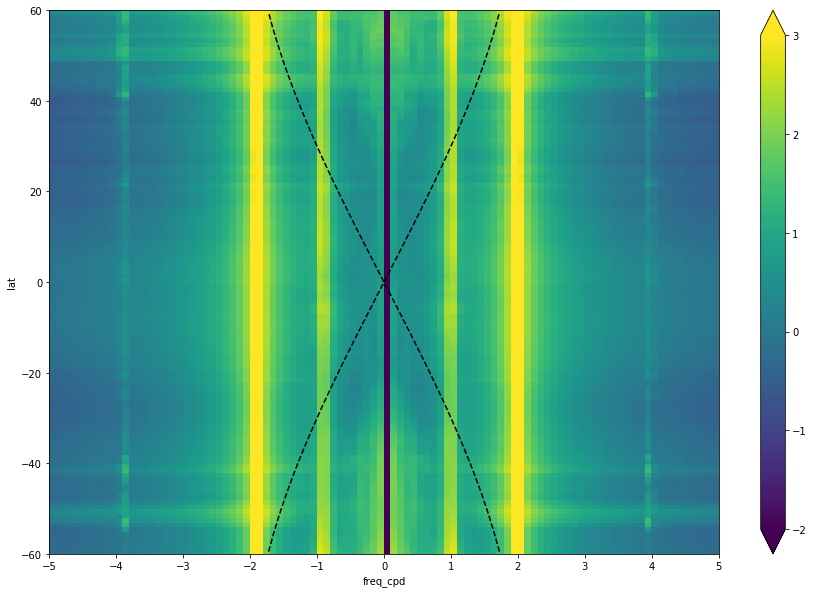

In [9]:

plt.figure(figsize=(15,10))
ax = plt.subplot(1,1,1)
E = E.assign_coords(freq_cpd=E.freq_time * 86400.)
np.log10(E).plot.pcolormesh(ax=ax, vmin=-2., vmax=3., x='freq_cpd', y='lat')
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-12., 12.)
ax.set_xlim(-5., 5.)

# add coriolis frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
ax.plot(f*86400./2./np.pi,f.lat,'k--')
ax.plot(-f*86400./2./np.pi,f.lat,'k--')


#, x=E.freq_time*86400)

---

In [10]:
client.restart()

Client Scheduler: tcp://10.148.0.5:8786 Dashboard: http://10.148.0.5:8787/status,Cluster Workers: 7 Cores: 98 Memory: 700.00 GB
